In [1]:
%matplotlib inline  
import gc
import pickle
import random
from multiprocessing import Pool

import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from numpy import random
import librosa
import numpy as np
import glob
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/home/jenazzad/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/jenazzad/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
input_length = 16000*2

batch_size = 32

def audio_norm(data):

    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+0.0001)
    return data-0.5


def load_audio_file(file_path, input_length=input_length):
    data = librosa.core.load(file_path, sr=16000)[0] #, sr=16000
    if len(data)>input_length:
        
        
        max_offset = len(data)-input_length
        
        offset = np.random.randint(max_offset)
        
        data = data[offset:(input_length+offset)]
        
        
    else:
        
        max_offset = input_length - len(data)
        
        offset = np.random.randint(max_offset)
        
        
        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        
        
    data = audio_norm(data)
    return data

In [3]:
train_files = glob.glob("../input/audio_train/*.wav")
test_files = glob.glob("../input/audio_test/*.wav")
train_labels = pd.read_csv("../input/train.csv")

In [4]:
file_to_label = {"../input/audio_train/"+k:v for k,v in zip(train_labels.fname.values, train_labels.label.values)}

In [5]:
#file_to_label

In [6]:
train_files[0]

'../input/audio_train/912c25f8.wav'

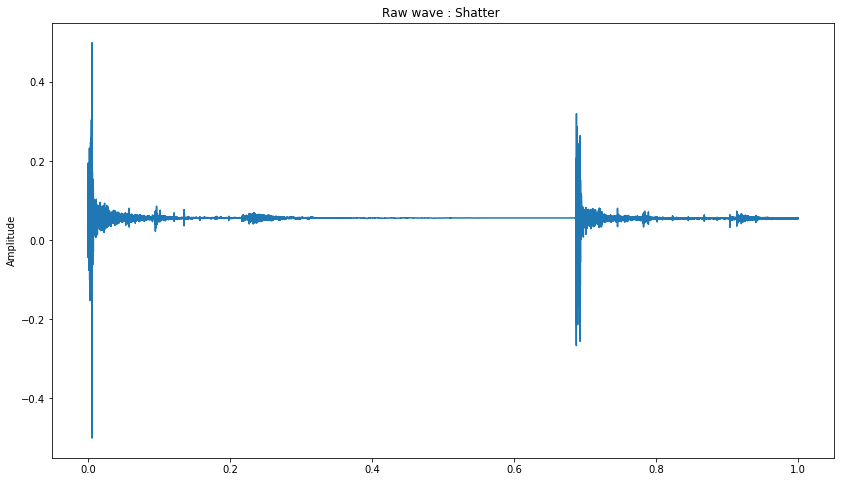

In [7]:
data_base = load_audio_file(train_files[0])
fig = plt.figure(figsize=(14, 8))
plt.title('Raw wave : %s ' % (file_to_label[train_files[0]]))
plt.ylabel('Amplitude')
plt.plot(np.linspace(0, 1, input_length), data_base)
plt.show()

In [8]:
list_labels = sorted(list(set(train_labels.label.values)))

In [9]:
label_to_int = {k:v for v,k in enumerate(list_labels)}

In [10]:
int_to_label = {v:k for k,v in label_to_int.items()}

In [11]:
file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}

In [12]:
def get_model():
    nclass = len(list_labels)
    inp = Input(shape=(input_length, 1))
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=16)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=4)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu)(img_1)
    dense_1 = Dense(1028, activation=activations.relu)(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.0001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

In [13]:
def chunker(seq, size):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

In [14]:
def train_generator(list_files, batch_size=batch_size):
    while True:
        shuffle(list_files)
        for batch_files in chunker(list_files, size=batch_size):
            batch_data = [load_audio_file(fpath) for fpath in batch_files]
            batch_data = np.array(batch_data)[:,:,np.newaxis]
            batch_labels = [file_to_int[fpath] for fpath in batch_files]
            batch_labels = np.array(batch_labels)
            
            yield batch_data, batch_labels
            

In [15]:
tr_files, val_files = train_test_split(train_files, test_size=0.1)

In [16]:
model = get_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32000, 1)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 31992, 16)         160       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 31984, 16)         2320      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1999, 16)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1999, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1997, 32)          1568      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1995, 32)          3104      
__________

In [17]:
model.fit_generator(train_generator(tr_files), steps_per_epoch=len(tr_files)//batch_size, epochs=2,
                    validation_data=train_generator(val_files), validation_steps=len(val_files)//batch_size,
                   use_multiprocessing=True, workers=8, max_queue_size=20)

/home/jenazzad/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/2
265/266 [============================>.] - ETA: 1s - loss: 3.6173 - acc: 0.0334

/home/jenazzad/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


266/266 [==============================] - 488s 2s/step - loss: 3.6180 - acc: 0.0338 - val_loss: 3.4016 - val_acc: 0.1045
Epoch 2/2
266/266 [==============================] - 491s 2s/step - loss: 3.2461 - acc: 0.0989 - val_loss: 3.0421 - val_acc: 0.1562


In [18]:
model.save_weights("baseline_cnn.h5")

In [19]:
list_preds = []


In [20]:
for batch_files in tqdm(chunker(test_files, size=batch_size), total=len(test_files)//batch_size ):
    batch_data = [load_audio_file(fpath) for fpath in batch_files]
    batch_data = np.array(batch_data)[:,:,np.newaxis]
    preds = model.predict(batch_data).tolist()
    list_preds += preds
            


  1%|▏         | 4/293 [00:16<19:32,  4.06s/it]


In [21]:
array_preds = np.array(list_preds)

In [22]:
list_labels = np.array(list_labels)

In [30]:
top_3 = list_labels[np.argsort(-array_preds, axis=1)[:, :3]] #https://www.kaggle.com/inversion/freesound-starter-kernel
pred_labels = [' '.join(list(x)) for x in top_3]

In [31]:
df = pd.DataFrame(test_files, columns=["fname"])
df['label'] = pred_labels

In [32]:
df['fname'] = df.fname.apply(lambda x: x.split("/")[-1])

In [33]:
df.to_csv("baseline.csv", index=False)